In [ ]:
import sys
import math
import random
import time
from PIL import Image
from multiprocessing import Queue
import numpy as np
import threading
#from cStringIO import StringIO
import io
from io import StringIO
import tensorflow as tf
import PIL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#workdir = '/content/drive/MyDrive/dataset_ml/amazon_men_actualizado/' #mario
workdir = '/content/drive/MyDrive/amazon_men_actualizado/'

Mounted at /content/drive


In [ ]:
user_train = np.load(workdir + 'dic_train_men.npy',allow_pickle='TRUE')
user_train=list(user_train.reshape(-1,1))[0][0]

user_test = np.load(workdir + 'dic_test_men.npy',allow_pickle='TRUE')
user_test=list(user_test.reshape(-1,1))[0][0]

Item = np.load(workdir + 'items_men.npy',allow_pickle='TRUE')
Item=list(Item.reshape(-1,1))[0][0]


In [ ]:
#Hyper-prameters
K = 100 # Latent dimensionality
lambda1 = 0.001 # Weight decay
lambda2 = 0.1 # Regularizer for theta_u
learning_rate = 0.1
training_epoch = 600
batch_size = 128 #4000
dropout = 0.5 # Dropout, probability to keep units
numldprocess=4 # multi-threading for loading images
usernum = len(user_train)

In [ ]:
set_im = []

for user in user_train:
  for item in range(len(user_train[user])):
    if user_train[user][item][b'productid'] not in set_im:
      set_im.append(user_train[user][item][b'productid'])
itemnum= len(set_im)

In [ ]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

def avgpool2d(x, k=2):
    return tf.nn.avg_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

weights = {
    'wc1': [11, 11, 3, 64],
    'wc2': [5, 5, 64, 256],
    'wc3': [3, 3, 256, 256],
    'wc4': [3, 3, 256, 256],
    'wc5': [3, 3, 256, 256],    
    'wd1': [7*7*256, 4096],
    'wd2': [4096, 4096],
    'wd3': [4096, K],
}

biases = {
    'bc1': [64],
    'bc2': [256],
    'bc3': [256],
    'bc4': [256],
    'bc5': [256],
    'bd1': [4096],
    'bd2': [4096],
    'bd3': [K],
}

def Weights(name):
    return tf.compat.v1.get_variable(name,dtype=tf.float32,shape=weights[name],initializer=tf.compat.v1.keras.initializers.glorot_normal())

def Biases(name):
    return tf.compat.v1.get_variable(name,dtype=tf.float32,initializer=tf.zeros(biases[name]))
       
# Create CNN model
def CNN(x,dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 224, 224, 3])


    conv1 = conv2d(x, Weights('wc1'), Biases('bc1'), strides=4)
    conv1 = tf.nn.relu(conv1)
    conv1 = maxpool2d(conv1, k=2)
    
    conv2 = conv2d(conv1, Weights('wc2'), Biases('bc2'))
    conv2 = tf.nn.relu(conv2)
    conv2 = maxpool2d(conv2, k=2)
    
    conv3 = conv2d(conv2, Weights('wc3'), Biases('bc3'))
    conv3 = tf.nn.relu(conv3)
    
    conv4 = conv2d(conv3, Weights('wc4'), Biases('bc4'))
    conv4 = tf.nn.relu(conv4)
    
    conv5 = conv2d(conv4, Weights('wc5'), Biases('bc5'))
    conv5 = tf.nn.relu(conv5)
    conv5 = maxpool2d(conv5, k=2)

    fc1 = tf.reshape(conv5, [-1,weights['wd1'][0]])
    fc1 = tf.add(tf.matmul(fc1, Weights('wd1')), Biases('bd1'))
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    
    fc2 = tf.add(tf.matmul(fc1, Weights('wd2')), Biases('bd2'))
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    
    fc3 = tf.add(tf.matmul(fc2, Weights('wd3')), Biases('bd3'))
    
    return fc3

In [ ]:
#define model
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()
with tf.device('/gpu:0'):
    #training sample
    queueu = tf.compat.v1.placeholder(dtype=tf.int32,shape=[1])
    queuei = tf.compat.v1.placeholder(dtype=tf.int32,shape=[1])
    queuej = tf.compat.v1.placeholder(dtype=tf.int32,shape=[1])
    queueimage1 = tf.compat.v1.placeholder(dtype=tf.uint8,shape=[224,224,3])
    queueimage2 = tf.compat.v1.placeholder(dtype=tf.uint8,shape=[224,224,3])
    batch_train_queue = tf.compat.v1.FIFOQueue(batch_size*5, dtypes=[tf.int32,tf.int32,tf.int32,tf.uint8,tf.uint8], shapes=[[1],[1],[1],[224,224,3],[224,224,3]])
    batch_train_queue_op = batch_train_queue.enqueue([queueu,queuei,queuej,queueimage1,queueimage2]);
    u,i,j,image1,image2 = batch_train_queue.dequeue_many(batch_size)

    image_test=tf.compat.v1.placeholder(dtype=tf.uint8,shape=[batch_size,224,224,3])
    
    image1=(tf.compat.v1.to_float(image1)-127.5)/127.5
    image2=(tf.compat.v1.to_float(image2)-127.5)/127.5
    _image_test=(tf.compat.v1.to_float(image_test)-127.5)/127.5

    u=tf.reshape(u,shape=[batch_size])
    i=tf.reshape(i,shape=[batch_size])
    j=tf.reshape(j,shape=[batch_size])
    
    keep_prob = tf.compat.v1.placeholder(tf.float32) #dropout (keep probability)

    #siamese networks
    with tf.compat.v1.variable_scope("DVBPR") as scope:
        result1 = CNN(image1,dropout) #primera cnn
        scope.reuse_variables() #pesos compartidos
        result2 = CNN(image2,dropout) #segunda cnn
        result_test = CNN(_image_test, 0.99) #dropout 1?
        nn_regularizers = sum(map(tf.nn.l2_loss,[Weights('wd1'), Weights('wd2'), Weights('wd3'), Weights('wc1'), Weights('wc2'), Weights('wc3'), Weights('wc4'), Weights('wc5')]))
        thetau = tf.Variable(tf.compat.v1.random_uniform([usernum,K],minval=0,maxval=1)/100)
   #loss
    cost_train = tf.reduce_sum(tf.compat.v1.log(tf.sigmoid(tf.reduce_sum(tf.multiply(tf.gather(thetau,u),tf.subtract(result1,result2)),1,keepdims=True))))
    regularizers = tf.nn.l2_loss(tf.gather(thetau,u))
    cost_train -= lambda1 * nn_regularizers + lambda2 * regularizers #regulariza pesos y norma de la representacion
    optimizer =  tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(-cost_train)  #adam
    
# Initializing the variables
init = tf.compat.v1.initialize_all_variables()


In [ ]:

def AUC(user_train, user_test, U, I):
  """
  para cada usuario cuenta cuantos items de una muestra aleatoria tiene rating menor a 
  al rating del item consumido en test
  """
  ans=0
  cc=0

  for user in user_test:
      item_test= user_test[user][0][b'productid']
      if item_test in set_im: #esta en train....
        item_test= set_im.index(item_test)
        T=np.dot(U[list(user_test.keys()).index(user),:],I.T)
        cc+=1
        no_considerar= set([set_im.index(user_train[user][item][b'productid']) for item in range(len(user_train[user]))]+ [item_test]) 
        count=0
        tmpans=0

        for j in random.sample(set_im,int(50*(len(no_considerar)-1))): #sample
            j= set_im.index(j)
            if j in no_considerar: continue
            if T[item_test] > T[j]:
              tmpans+=1
            count +=1

        tmpans/=float(count)
        ans+=tmpans
  
  ans/=float(cc)
  return ans

def Evaluation(step): #para cada epoca???? 
    print ('...')
    U=sess.run(thetau) #representacion visual del usuario
    I=np.zeros([itemnum,K],dtype=np.float32) #matriz para guardar todas las representaciones de las imagenes en K dim
    idx=np.array_split(range(itemnum),(itemnum+batch_size-1)/batch_size) #np.array_split(range(itemnum),5)
    
    input_images=np.zeros([batch_size,224,224,3],dtype=np.int8)
    for i in range(len(idx)): 
        print("minibatch: ", i,"/",len(idx))
        cc=0
        for j in idx[i]: #para cada elemento del minibatch i
             #accedo a los indices de imagenes que corresponden
            img_ = PIL.Image.open(io.BytesIO(Item[ set_im[j]][b'imgs']))
            input_images[cc]=np.uint8(np.asarray( img_.convert('RGB').resize((224,224)))) #guarda la imagen
            cc+=1
        #en cada minibatch ejecuta y guarda
        I[idx[i][0]:(idx[i][-1]+1)]=sess.run(result_test,feed_dict={image_test:input_images})[:(idx[i][-1]-idx[i][0]+1)]
    print ('export finised! lei las imagenes')
    np.save('UI_'+str(K)+'_'+str(step)+'.npy',[U,I])
    return AUC(user_train,user_train,U,I), AUC(user_train,user_test,U,I) #train, test

def sample(user):
    u = random.choice(list(user.keys()))#user id random
    numu = len(user[u]) # cantidad de items consumidos por ese usuario
    i = set_im.index(user[u][random.randrange(numu)][b'productid']) #escoger un producto id al azar de esos
    M=set()
    for item in user[u]:
        M.add(set_im.index(item[b'productid'])) #se crea el conjunto M de productos unicos del usuario

    while True:
        j= set_im.index(random.choice(set_im)) #se escoge un item al azar
        if (not j in M): break #si el item no fue consumido por el usuario listo...
        
    return (u,i,j)


def load_image_async(): #carga imagenes
    print("load_image")
    while True:
        (uuu,iii,jjj)=sample(user_train)
        #iii_fix= set_im.index(iii)
        #jjj_fix= set_im.index(jjj)
        #print("index: ", iii_fix, "item", iii, "\n")
        img = PIL.Image.open(io.BytesIO(Item[set_im[iii]][b'imgs']))
        jpg1=np.uint8(np.asarray( img.convert('RGB').resize((224,224))))
        img_j = PIL.Image.open(io.BytesIO(Item[set_im[jjj]][b'imgs'])) 
        jpg2=np.uint8(np.asarray( img_j.convert('RGB').resize((224,224))))

        sess.run(batch_train_queue_op,feed_dict={queueu:np.asarray([uuu]),
                                                 queuei:np.asarray([iii]),
                                                 queuej:np.asarray([jjj]),
                                                 queueimage1:jpg1,queueimage2:jpg2,
                                                })

In [ ]:
%%time
f=open('DVBPR.log','w')
config = tf.compat.v1.ConfigProto(log_device_placement=False,allow_soft_placement=True)
sess=tf.compat.v1.Session(config=config)
sess.run(init)

gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

t=[0]*numldprocess
for i in range(numldprocess):
    t[i] = threading.Thread(target=load_image_async)
    t[i].daemon=True
    t[i].start()

oneiteration = 0
for item in user_train: oneiteration+=len(user_train[item]) # total interacciones

step = 1
saver = tf.compat.v1.train.Saver([k for k in tf.compat.v1.global_variables() if k.name.startswith('DVBPR')])

epoch=0
print("inicia train")

load_image
load_image
load_image
load_image
inicia train
CPU times: user 654 ms, sys: 228 ms, total: 881 ms
Wall time: 768 ms


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
print("cantidad de epocas convolucionales: ",int((training_epoch*oneiteration+1)/batch_size) )

cantidad de epocas convolucionales:  60393


In [ ]:
%%time
loss=[]
while step * batch_size <= training_epoch*oneiteration+1: # cuantas veces supera la cantidad de interacciones

    _,l=sess.run([optimizer,cost_train], feed_dict={keep_prob: dropout})
    loss.append(l)
    if step%1000==0:
        print ('Step#'+str(step)+' CNN update') # loss: '+ str(-l) )
    
    #loss.append(-l)
   # if step % 100000==0: # mostrar algunas veces los resultados...
    #    epoch+=1
     #   saver.save(sess,'./DVBPR_auc_'+str(K)+'_'+str(step)+'.ckpt')
      #  auc_train,auc_test=Evaluation(step)
       # print ('Epoch #'+str(epoch)+': test: '+str(auc_test)+' train: '+str(auc_train)+'\n')
        #f.write('Epoch #'+str(epoch)+': test: '+str(auc_test)+' train: '+str(auc_train)+'\n')
        #f.flush()
    
    step += 1
print ("Optimization Finished!")


Step#1000 CNN update
Step#2000 CNN update
Step#3000 CNN update
Step#4000 CNN update
Step#5000 CNN update
Step#6000 CNN update
Step#7000 CNN update
Step#8000 CNN update
Step#9000 CNN update
Step#10000 CNN update
Step#11000 CNN update
Step#12000 CNN update
Step#13000 CNN update
Step#14000 CNN update
Step#15000 CNN update
Step#16000 CNN update
Step#17000 CNN update
Step#18000 CNN update
Step#19000 CNN update
Step#20000 CNN update
Step#21000 CNN update
Step#22000 CNN update
Step#23000 CNN update
Step#24000 CNN update
Step#25000 CNN update
Step#26000 CNN update
Step#27000 CNN update
Step#28000 CNN update
Step#29000 CNN update
Step#30000 CNN update
Step#31000 CNN update
Step#32000 CNN update
Step#33000 CNN update
Step#34000 CNN update
Step#35000 CNN update
Step#36000 CNN update
Step#37000 CNN update
Step#38000 CNN update
Step#39000 CNN update
Step#40000 CNN update
Step#41000 CNN update
Step#42000 CNN update
Step#43000 CNN update
Step#44000 CNN update
Step#45000 CNN update
Step#46000 CNN upda

In [ ]:
auc_train,auc_test=Evaluation(step)
print("auc train: ", auc_train," auc test: ", auc_test)
np.save(workdir+"resultado.npy", [auc_train,auc_test])
np.save(workdir+"perdida.npy",loss)

...
minibatch:  0 / 72
minibatch:  1 / 72
minibatch:  2 / 72
minibatch:  3 / 72
minibatch:  4 / 72
minibatch:  5 / 72
minibatch:  6 / 72
minibatch:  7 / 72
minibatch:  8 / 72
minibatch:  9 / 72
minibatch:  10 / 72
minibatch:  11 / 72
minibatch:  12 / 72
minibatch:  13 / 72
minibatch:  14 / 72
minibatch:  15 / 72
minibatch:  16 / 72
minibatch:  17 / 72
minibatch:  18 / 72
minibatch:  19 / 72
minibatch:  20 / 72
minibatch:  21 / 72
minibatch:  22 / 72
minibatch:  23 / 72
minibatch:  24 / 72
minibatch:  25 / 72
minibatch:  26 / 72
minibatch:  27 / 72
minibatch:  28 / 72
minibatch:  29 / 72
minibatch:  30 / 72
minibatch:  31 / 72
minibatch:  32 / 72
minibatch:  33 / 72
minibatch:  34 / 72
minibatch:  35 / 72
minibatch:  36 / 72
minibatch:  37 / 72
minibatch:  38 / 72
minibatch:  39 / 72
minibatch:  40 / 72
minibatch:  41 / 72
minibatch:  42 / 72
minibatch:  43 / 72
minibatch:  44 / 72
minibatch:  45 / 72
minibatch:  46 / 72
minibatch:  47 / 72
minibatch:  48 / 72
minibatch:  49 / 72
miniba

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


auc train:  0.0  auc test:  0.0


In [ ]:
loss=np.load(workdir+"perdida.npy")

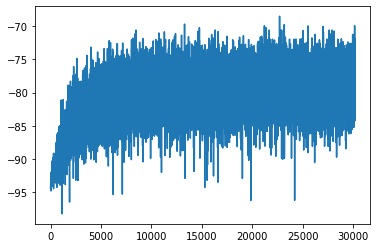

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(loss)), loss)